# Hop Teaming Analysis - Attempt at geolocation

## Team: The Hindenburgs

Tomo Umer

In [1]:
import pandas as pd
import sqlite3
import requests
import matplotlib.pyplot as plt
import json
import time
import geopandas as gpd
from shapely.geometry import Point
import shapely

In [2]:
louvain_community = pd.read_csv('../data/louvain_community.csv')

In [3]:
louvain_community.head()

,name,communityId
0,1003013160,1448
1,1003013947,5724
2,1003019902,7592
3,1003028770,7643
4,1003031261,1018


In [4]:
# First group by community
louvain_community_largegroups = louvain_community.groupby('communityId').count().reset_index()

# Filter out any communities that have less than 10 NPIs
louvain_community_largegroups = louvain_community_largegroups.loc[louvain_community_largegroups['name']>= 10]

# Filter to NPIs that appear in those "large" communities
louvain_community = louvain_community.loc[louvain_community['communityId'].isin(louvain_community_largegroups['communityId'])]

Only 22 communities have 10 or more NPIs within and they correspond to 7788 NPIs -> that's what I will attempt to put on a map.

In [5]:
npi_communities = tuple(louvain_community['name'].tolist())

query =f"""
SELECT *
FROM nnpes
WHERE npi IN {npi_communities}
"""


with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    communities = pd.read_sql(query, db)

communities.head()

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy
0,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,None,CLARKSVILLE,TN,37043,207Q00000X
1,1003013947,1.0,None,OTTO,ROBERT,JOEL,DR.,None,M.D.,2400 PATTERSON ST STE 100,None,NASHVILLE,TN,37203,207X00000X
2,1003019902,1.0,None,ACOSTA,LEALANI,MAE,None,None,MD,3601 TVC,None,NASHVILLE,TN,37232,2084N0400X
3,1003028770,2.0,SPRING HILL DERMATOLOGY PLC,None,None,None,None,None,None,1229 RESERVE BLVD,SUITE 200,SPRING HILL,TN,37174,207N00000X
4,1003031261,1.0,None,RUBRIGHT,JAMES,HARDMAN,None,None,M.D.,345 23RD AVE N,SUITE 212,NASHVILLE,TN,37203,207XS0106X


In [6]:
communities = pd.merge(left = communities, right = louvain_community, 
                        left_on = 'npi', right_on = 'name')

communities = communities.drop(columns='name')

In [10]:
# testing the regex
communities.loc[communities['first_line_address'].str.contains(' AT.')]

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy,communityId
2659,1336292465,2.0,"ATHENA CONSULTING AND PSYCHOLOGICAL SERVICES, ...",None,None,None,None,None,None,220 ATHENS WAY STE 104,None,NASHVILLE,TN,37228,103TC0700X,7592
2861,1366441891,1.0,None,ANDERSON,CHARLOTTE,ANN,MS.,None,CRNA,4163 VILLAGE AT VANDERBILT,None,NASHVILLE,TN,37232,367500000X,7592
3441,1427504539,1.0,None,NEWTON,ARIEL,None,None,None,None,220 ATHENS WAY STE 104,None,NASHVILLE,TN,37228,363LP0808X,7643
5868,1740345438,1.0,None,IHRIG,BERNARD,CHARLES,DR.,None,PHD,220 ATHENS WAY STE 104,None,NASHVILLE,TN,37228,103T00000X,7592


In [13]:
# This below is needed because around 1250 addresses have STE in the first address line and that is not usable with nominatim openstreetmap
communities['first_line_address'] = communities['first_line_address'].str.replace(' STE.+', '', regex=True)

# another 104 that end in ST + number
communities['first_line_address'] = communities['first_line_address'].str.replace(' ST\d.+', '', regex=True)

# 7 with appartments
communities['first_line_address'] = communities['first_line_address'].str.replace(' APT.', '', regex=True)

In [14]:
# adding the two new columns that will have the lat and long
communities['lat'] = ''
communities['lon'] = ''

In [ ]:
# this was for testing single iteration
# endpoint = 'https://nominatim.openstreetmap.org/search'

# params = {
#     'street' : communities.loc[0 ,'first_line_address'],
#     'city' : communities.loc[0, 'address_city_name'],
#     'state' : communities.loc[0, 'address_state_name'],
#     'postalcode' : communities.loc[0, 'address_postal_code'],
#     'format' : 'json'
# }

# response = requests.get(endpoint, params = params)

# print(response.url)
# print(response.status_code)

# if response.json() != []:
#     print(response.json()[0]['lat'])
#     print(response.json()[0]['lon'])


In [15]:
def latlong_go_getter(street, city, state, zip):
    endpoint = 'https://nominatim.openstreetmap.org/search'

    params = {
    'street' : street,
    'city' : city,
    'state' : state,
    'postalcode' : zip,
    'format' : 'json'
    }
    
    response = requests.get(endpoint, params = params)
    tm=0

    while response.status_code != 200:
        print('waiting for ' + row_nr)
        time.sleep(10)
        response = requests.get(endpoint, params = params)
        tm = tm + 1
        if tm == 10:
            break

    results = response.json()

    if results:
        return results[0]['lat'], results[0]['lon']
    else:
        return '', ''


> NOTE: running the code below takes about an hour!! so only uncomment the first time and then save to csv

In [ ]:

# communities[['lat', 'lon']] = communities.apply(lambda row: pd.Series(latlong_go_getter(row['first_line_address'], row['address_city_name'], row['address_state_name'], row['address_postal_code'])), axis=1)

In [ ]:
#communities.to_csv('../data/communities_map.csv')

In [16]:
communities = pd.read_csv('../data/communities_map.csv').drop(columns='Unnamed: 0')

In [17]:
communities = pd.merge(left = communities, right = louvain_community, 
                        left_on = 'npi', right_on = 'name')

communities = communities.drop(columns='name')

In [18]:
# missing 2057 addresses!
communities = communities.loc[~communities['lat'].isna()]

In [19]:
# load in ALL of the CBSA (from all of us)
cbsa_34980 = gpd.read_file('../data/tl_2020_us_cbsa/tl_2020_us_cbsa.shp')

# select only the one we're interested in
cbsa_34980 = cbsa_34980.loc[cbsa_34980['CBSAFP'] == '34980']

In [20]:
communities['geometry'] = gpd.points_from_xy(communities['lon'], communities['lat'])

communities.head()

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy,lat,lon,communityId,geometry
0,1003013160,1.0,NaN,GRABENSTEIN,WILLIAM,P.,DR.,NaN,M.D.,1822 MEMORIAL DR,NaN,CLARKSVILLE,TN,37043,207Q00000X,36.519568,-87.306305,1448,POINT (-87.30630 36.51957)
1,1003013947,1.0,NaN,OTTO,ROBERT,JOEL,DR.,NaN,M.D.,2400 PATTERSON ST,NaN,NASHVILLE,TN,37203,207X00000X,36.151837,-86.809838,5724,POINT (-86.80984 36.15184)
3,1003028770,2.0,SPRING HILL DERMATOLOGY PLC,NaN,NaN,NaN,NaN,NaN,NaN,1229 RESERVE BLVD,SUITE 200,SPRING HILL,TN,37174,207N00000X,35.737755,-86.895160,7643,POINT (-86.89516 35.73775)
4,1003031261,1.0,NaN,RUBRIGHT,JAMES,HARDMAN,NaN,NaN,M.D.,345 23RD AVE N,SUITE 212,NASHVILLE,TN,37203,207XS0106X,36.154777,-86.809139,1018,POINT (-86.80914 36.15478)
5,1003037029,1.0,NaN,STONE,RALPH,OWENS,NaN,NaN,DC,1700 CARMACK BLVD,NaN,COLUMBIA,TN,38401,111N00000X,35.605296,-87.035270,7643,POINT (-87.03527 35.60530)


In [21]:
communities_geo = gpd.GeoDataFrame(communities, 
                                    crs = cbsa_34980.crs, 
                                    geometry = communities['geometry'])

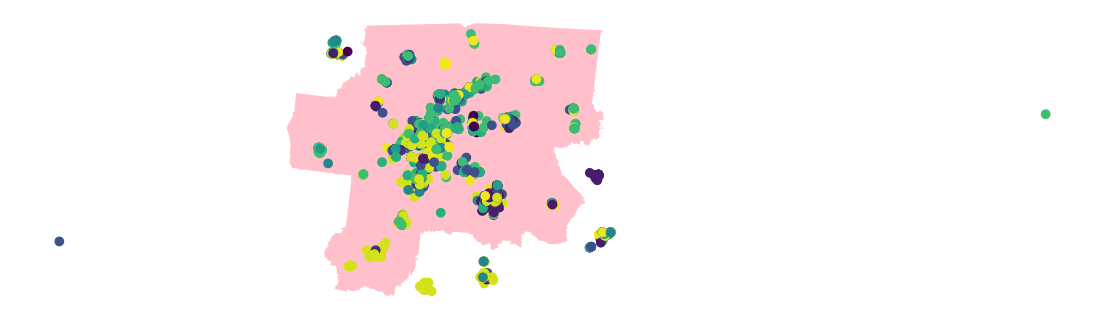

In [29]:
ax = cbsa_34980.plot(figsize=(14,14), color = 'pink')
communities_geo.plot(ax = ax, column = 'communityId')
ax.axis('off');

In [30]:
communities.loc[communities['lon'] < -88]

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy,lat,lon,communityId,geometry
6633,1851334528,2.0,"MADISON RESIDENTIAL, LLC",NaN,NaN,NaN,NaN,NaN,NaN,527 OLD HICKORY BLVD,NaN,MADISON,TN,37115,310400000X,35.658455,-88.847548,2322,POINT (-88.84755 35.65846)
